In [18]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras import layers, models, optimizers, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, AdamW
from tensorflow.keras.layers import Dense, Flatten, Dropout, Conv2D, GlobalAveragePooling2D
from tensorflow.keras.utils import plot_model
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data() #load
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0
x_train = tf.expand_dims(x_train, -1)
x_test = tf.expand_dims(x_test, -1)
y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


I0000 00:00:1758873851.812903      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758873851.813624      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


In [3]:
def conv_model(input_shape=(28, 28, 1)):
  model = Sequential([
      layers.Conv2D(32, 3, (1,1), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01), input_shape=input_shape),
      layers.Conv2D(32, 3, (1,1), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
      layers.MaxPooling2D((2,2)),
      layers.Conv2D(64, 3, (1,1), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
      layers.Conv2D(64, 3, (1,1), activation='relu', padding='same', kernel_regularizer=regularizers.l2(0.01)),
      layers.MaxPooling2D((2,2)),

      layers.Flatten(),
      layers.Dense(128, activation='relu'),
      layers.Dense(10, activation='softmax')
  ])
  plot_model(model, to_file='conv_model.png', show_shapes=True, show_layer_names=True)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

In [4]:
#let's create the ResNet model
def resnet_block(x, filters, stride=1, weight_decay=0.0):
  shortcut = x
  x = layers.Conv2D(filters, 3, strides = stride, padding = 'same', use_bias = False, kernel_regularizer = regularizers.l2(weight_decay))(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)
  x = layers.Conv2D(filters, 3, strides = 1, padding = 'same', use_bias = False, kernel_regularizer = regularizers.l2(weight_decay))(x)
  x = layers.BatchNormalization()(x)
  if stride != 1 or shortcut.shape[-1] != filters:
    shortcut = layers.Conv2D(filters, 1, strides = stride, use_bias = False, kernel_regularizer = regularizers.l2(weight_decay))(shortcut)
    shortcut = layers.BatchNormalization()(shortcut)
    x = layers.Add()([x, shortcut])
  x = layers.Activation('relu')(x)
  return x

def resnet(input_shape=(28, 28, 1), num_classes=10, weight_decay=0.0):
  inputs = layers.Input(shape=input_shape)
  x = layers.Conv2D(32, 3, strides = 1, padding = 'same', use_bias = False, kernel_regularizer = regularizers.l2(weight_decay))(inputs)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = resnet_block(x, 32, 1, weight_decay)
  x = resnet_block(x, 32, 1, weight_decay)

  x = resnet_block(x, 64, 2, weight_decay)
  x = resnet_block(x, 64, 1, weight_decay)

  x = resnet_block(x, 128, 2, weight_decay)
  x = resnet_block(x, 128, 1, weight_decay)

  x = layers.GlobalAveragePooling2D()(x)
  outputs = layers.Dense(num_classes, activation='softmax')(x) # Added this line

  model = models.Model(inputs, outputs) # Changed x to outputs
  plot_model(model, to_file='resnet_model.png', show_shapes=True, show_layer_names=True)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model


In [5]:
history_conv = conv_model().fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


I0000 00:00:1758873856.508883     102 service.cc:148] XLA service 0x7d29280040d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758873856.509443     102 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758873856.509459     102 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758873856.838468     102 cuda_dnn.cc:529] Loaded cuDNN version 90300


  48/1875 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.3089 - loss: 2.8896    

I0000 00:00:1758873859.592257     102 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 4ms/step - accuracy: 0.8937 - loss: 0.5821 - val_accuracy: 0.9777 - val_loss: 0.1351
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9758 - loss: 0.1412 - val_accuracy: 0.9767 - val_loss: 0.1221
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9808 - loss: 0.1139 - val_accuracy: 0.9822 - val_loss: 0.0998
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9831 - loss: 0.0999 - val_accuracy: 0.9876 - val_loss: 0.0817
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9871 - loss: 0.0837 - val_accuracy: 0.9871 - val_loss: 0.0772
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9873 - loss: 0.0784 - val_accuracy: 0.9867 - val_loss: 0.0797
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 3ms/step - accuracy: 0.9892 - loss: 0.0730 - val_accuracy: 0.9871 - val_loss: 0.0730
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9903 - loss: 0.0646 - val_accura

In [6]:
history_resnet = resnet().fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - accuracy: 0.9297 - loss: 0.2491 - val_accuracy: 0.9817 - val_loss: 0.0559
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9861 - loss: 0.0445 - val_accuracy: 0.9890 - val_loss: 0.0347
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 11ms/step - accuracy: 0.9898 - loss: 0.0361 - val_accuracy: 0.9774 - val_loss: 0.0740
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9914 - loss: 0.0281 - val_accuracy: 0.9918 - val_loss: 0.0273
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9929 - loss: 0.0223 - val_accuracy: 0.9909 - val_loss: 0.0287
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9940 - loss: 0.0198 - val_accuracy: 0.9914 - val_loss: 0.0279
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - accuracy: 0.9947 - loss: 0.0167 - val_accuracy: 0.9931 - val_loss: 0.0224
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - accuracy: 0.9953 -

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

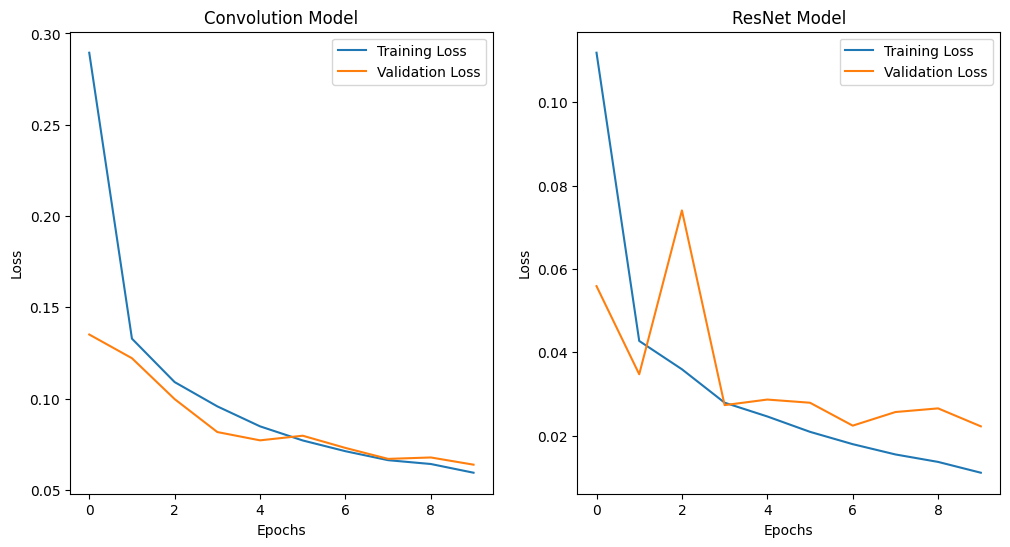

In [7]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.lineplot(history_conv.history['loss'], label='Training Loss')
sns.lineplot(history_conv.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.title("Convolution Model")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1,2,2)
sns.lineplot(history_resnet.history['loss'], label='Training Loss')
sns.lineplot(history_resnet.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("ResNet Model")
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

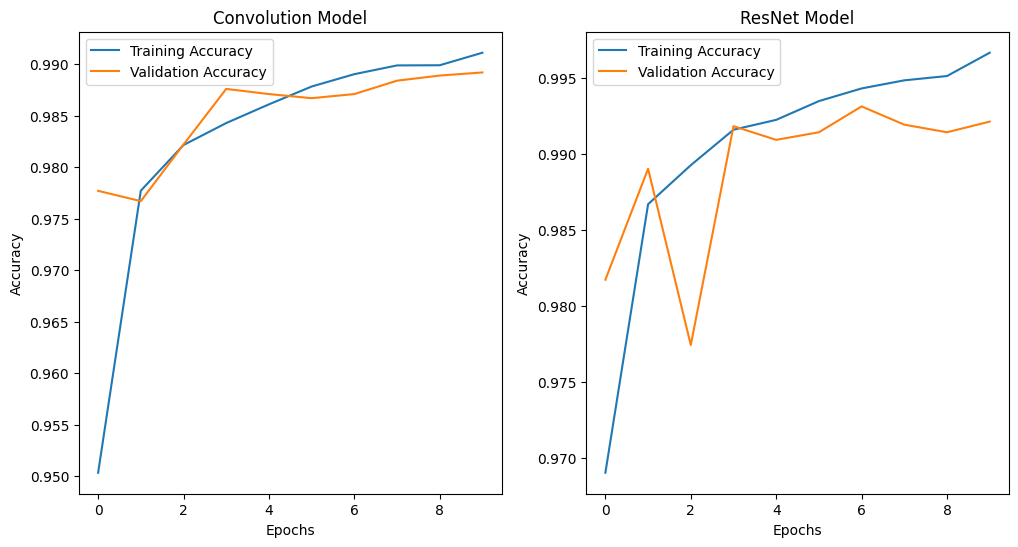

In [8]:
plt.figure(figsize=(12, 6))
plt.subplot(1,2,1)
sns.lineplot(history_conv.history['accuracy'], label='Training Accuracy')
sns.lineplot(history_conv.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.title("Convolution Model")
plt.ylabel("Accuracy")
plt.legend()
plt.subplot(1,2,2)
sns.lineplot(history_resnet.history['accuracy'], label='Training Accuracy')
sns.lineplot(history_resnet.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("ResNet Model")
plt.legend()
plt.show()

In [9]:
model_conv = conv_model()
model_resnet= resnet()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
loss_fn = tf.keras.losses.CategoricalCrossentropy()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_dataset = train_dataset.shuffle(10000).batch(32)

In [11]:
x_batch, y_batch = next(iter(train_dataset))

with tf.GradientTape() as tape:
    logits= model_conv(x_batch, training=True)
    loss= loss_fn(y_batch, logits)

grads = tape.gradient(loss, model_conv.trainable_weights)    

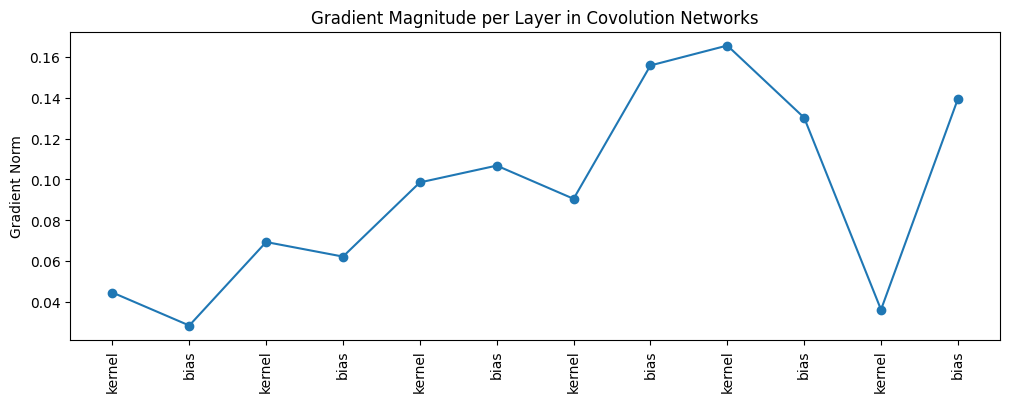

In [12]:
grad_norms = []
layer_names = []

for var, grad in zip(model_conv.trainable_weights, grads):
    if grad is not None:
        grad_norms.append(tf.norm(grad).numpy())
        layer_names.append(var.name)

plt.figure(figsize=(12,4))
plt.plot(grad_norms, marker='o')
plt.xticks(range(len(layer_names)), layer_names, rotation=90)
plt.ylabel("Gradient Norm")
plt.title("Gradient Magnitude per Layer in Covolution Networks")
plt.show()

In [13]:
with tf.GradientTape() as tape:
    logits= model_resnet(x_batch, training=True)
    loss= loss_fn(y_batch, logits)

grads_rn = tape.gradient(loss, model_resnet.trainable_weights) 

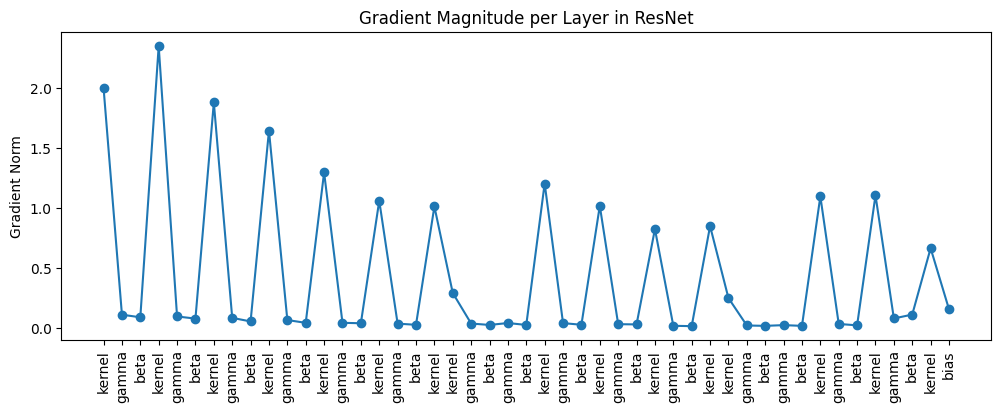

In [14]:
grad_norms_resnet = []
layer_names_resnet = []

for var, grad in zip(model_resnet.trainable_weights, grads_rn):
    if grad is not None:
        grad_norms_resnet.append(tf.norm(grad).numpy())
        layer_names_resnet.append(var.name)

plt.figure(figsize=(12,4))
plt.plot(grad_norms_resnet, marker='o')
plt.xticks(range(len(layer_names_resnet)), layer_names_resnet, rotation=90)
plt.ylabel("Gradient Norm")
plt.title("Gradient Magnitude per Layer in ResNet")
plt.show()

In [16]:
model_resnet.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 28, 28, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 28, 28,    │        288 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_23[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_13       │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (None, 28, 28,    │      9,216 │ activation_13[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_24[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_14       │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (None, 28, 28,    │      9,216 │ activation_14[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_25[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_15       │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (None, 28, 28,    │      9,216 │ activation_15[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_26[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_16       │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_27 (Conv2D)  │ (None, 28, 28,    │      9,216 │ activation_16[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 28, 28,    │        128 │ conv2d_27[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_17       │ (None, 28, 28,    │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_28 (Conv2D)  │ (None, 14, 14,    │     18,432 │ activation_17[0]

 Total params: 698,282 (2.66 MB)

 Trainable params: 696,042 (2.66 MB)

 Non-trainable params: 2,240 (8.75 KB)

In [21]:
def get_last_conv_layer(model):
    # Automatically find the last Conv2D layer
    for layer in reversed(model.layers):
        if isinstance(layer, tf.keras.layers.Conv2D):
            return layer.name
    raise ValueError("No Conv2D layer found in the model.")

def make_gradcam_heatmap(img_array, model, pred_index=None):
    last_conv_layer_name = get_last_conv_layer(model)
    last_conv_layer = model.get_layer(last_conv_layer_name)
    
    grad_model = tf.keras.models.Model(
        [model.inputs],
        [last_conv_layer.output, model.output]
    )
    
    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(predictions[0])
        class_channel = predictions[:, pred_index]

    grads = tape.gradient(class_channel, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)
    
    heatmap = tf.maximum(heatmap, 0)
    heatmap /= tf.reduce_max(heatmap)
    
    return heatmap.numpy()

def overlay_heatmap(img, heatmap, alpha=0.4, colormap=cv2.COLORMAP_JET):
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, colormap)
    overlayed = cv2.addWeighted(img, 1-alpha, heatmap, alpha, 0)
    return overlayed

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: [['keras_tensor_68']]
Received: inputs=Tensor(shape=(1, 28, 28, 1))
  warnings.warn(msg)


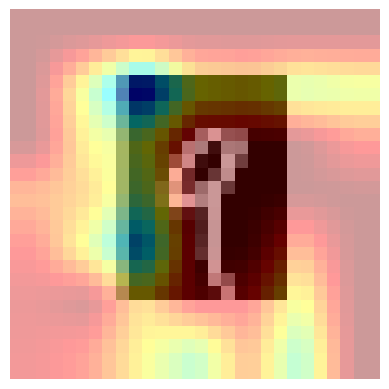

In [ ]:
img = cv2.imread('/kaggle/input/images/images.png', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (28, 28))
img = img.astype('float32') / 255.0

img_array = np.expand_dims(img, axis=-1)       # shape: (28,28,1)
img_array = np.expand_dims(img_array, axis=0)  # shape: (1,28,28,1)

heatmap = make_gradcam_heatmap(img_array, model_resnet)

img_bgr = cv2.cvtColor((img*255).astype(np.uint8), cv2.COLOR_GRAY2BGR)

overlayed_img = overlay_heatmap(img_bgr, heatmap)

plt.imshow(overlayed_img)
plt.title("Grad-CAM Overlay on Input Image")
plt.axis('off')
plt.show()